In [1]:
#!pip install xgboost

# XGBoost

[[XGB Document](https://xgboost.readthedocs.io/en/stable/index.html)]
- Extreme Gradient Boosting의 약자
- 베이스모델로 의사결정나무를 사용하는 GBM 기반의 머신러닝 알고리즘
- GBM과 동일하게 이전라운드에서의 예측오류를 다음 라운드의 모델 학습에 반영시킨다.
- 하지만 GBM과 달리 학습을 위한 목적함수에 트리 규제항(Regularization Term) $Ω(ℎ)$이 추가됨  
- 병렬 학습이 가능하여 GBM에 비해 학습시간이 빠르며, 규제항으로 인하여 과적합이 발생할 가능성이 더 낮다는 장점      
![목적함수](img\xgb목적함수.png)  
---  
![규제항](img\xgb규제항.png)  
- 규제항 $Ω(ℎ)$은 트리의 복잡성에 패널티를 부여하는 항. 과적합 방지
    - ①번 항은 트리가 커짐에 따라 패널티 부여
    - ②번 항은 특정 끝노드에서의 출력값이 커지는 것에 대한 패널티
- 𝛾는 하이퍼파라미터로 트리의 복잡도에 대한 패널티를 의미한다. 값을 크게 할 수록 더욱 많은 가지치기가 수행됨.

### 1. 데이터 로드 및 전처리

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib

#한글꺠짐 방지
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [3]:
data=pd.read_csv("./data/class_balance.csv",encoding="EUC-KR")

In [4]:
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X466,X467,X468,X469,X470,X471,X472,X473,X474,Y
0,0.457896,0.530189,0.276976,0.359864,0.193059,0.322190,0.706897,0.553781,0.653894,0.375204,...,0.246376,0.711806,0.008532,0.013672,0.008467,0.402240,0.238811,0.274876,0.210238,-1
1,0.607100,0.341478,0.518992,0.395300,0.042071,0.469654,0.750000,0.542031,0.447466,0.189233,...,0.523785,0.760417,0.030930,0.033203,0.029759,0.210356,0.309339,0.328358,0.439175,-1
2,0.360781,0.369653,0.341039,0.021697,0.181737,0.528684,0.491379,0.516722,0.300371,0.376835,...,0.185769,0.659722,0.005333,0.003906,0.005311,0.381877,0.208171,0.208955,0.155761,-1
3,0.460910,0.413500,0.535685,0.302794,0.242326,0.408966,0.646552,0.561615,0.415328,0.313214,...,0.246376,0.000000,1.000000,1.000000,1.000000,0.381877,0.208171,0.208955,0.155761,-1
4,0.263068,0.279821,0.535685,0.302794,0.242326,0.408966,0.646552,0.638747,0.660074,0.520392,...,0.110711,0.517361,0.023677,0.022461,0.023447,0.608414,0.212062,0.268657,0.092827,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,0.360022,0.396033,0.382803,0.070771,0.143308,0.920884,0.586207,0.636336,0.337454,0.432300,...,0.000000,0.597222,0.016212,0.013672,0.015997,0.045307,0.147860,0.171642,0.000000,1
250,0.508628,0.437628,0.192378,0.061866,0.168425,0.481919,0.715517,0.270563,0.407911,0.336052,...,0.132582,0.975694,0.017065,0.015625,0.016114,0.543689,0.227626,0.320896,0.111165,1
251,0.275930,0.364365,0.302236,0.376615,0.485135,0.627270,0.594828,0.435673,0.420272,0.367047,...,0.246376,0.586806,0.008532,0.015625,0.008613,0.343042,0.151751,0.164179,0.143012,1
252,0.785179,0.271804,0.400189,0.457851,0.229526,0.244320,0.396552,0.875565,0.110012,0.337684,...,0.221768,0.767361,0.024317,0.019531,0.023461,0.509709,0.398833,0.440299,0.185945,1


In [5]:
data['Y'] = data['Y'].map(lambda x: 0 if x == -1 else 1) # 기존 -1, 1이었던 Y값을 모델 학습을 위해 0, 1로 변경

In [6]:
# X, Y 분할
Y=data["Y"].copy()
X=data.drop("Y",axis=1)
X.head(3)

# X
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22,shuffle =True)

[[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)]  
**sklearn.model_selection.train_test_split**
- **test_size** : float or int, default = 0.25, 정수값일시 test사이즈로 설정하고 싶은 샘플 수 입력
- **train_size** : float or int, default = None
- **random_state** : int, default = None, 랜덤 seed값 설정, 같은 seed 내에선 동일결과 추출 
- **shuffle** : bool, default = True, 데이터셋 무작위 추출, 시계열 데이터와 같이 순차적 추출이 필요한 경우엔 Shuffle = False!
- **stratify** : array-like, default = None, True일시 계층적 샘플링 진행 ([참고](https://www.investopedia.com/terms/stratified_random_sampling.asp))

### 2. 평가 지표 함수

![Confusion Matrix](https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg)

###### 이미지 출처 : https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html

In [7]:
# 평가 지표 출력 함수
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix

def print_all_reg(Y_test,pred):
    # Specificity를 구하기 위해 confusion matrix를 이용
    cm1 = confusion_matrix(Y_test,pred)
    specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    
    #결과 검사
    #recall = cm1[1,1]/(cm1[1,1]+cm1[1,0])
    #pre = cm1[1,1]/(cm1[1,1]+cm1[0,1])

    G_mean = recall_score(Y_test,pred) * specificity1
    
    print("model의 recall 값은 {:.3f}".format(recall_score(Y_test,pred)))
    print("model의 2종 오류 확률 값은 {:.3f}".format(1-recall_score(Y_test,pred)))
    print("model의 Specificity 값은 {:.3f}".format(specificity1))
    print("model의 1종 오류 확률 값은 {:.3f}".format(1-specificity1))
    print("model의 precision 값은 {:.3f}".format(precision_score(Y_test,pred)))
    print("model의 f1_score 값은 {:.3f}".format(f1_score(Y_test,pred)))
    print("model의 G-mean 값은 {:.3f}".format(np.sqrt(G_mean)))
    print("model의 accuracy 값은 {:.3f}".format(accuracy_score(Y_test,pred)))


### 3. 모델 학습 및 예측

[[XGB Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)]
##### General Parameters
- **booster** [default= gbtree ] : 어떤 부스터 구조를 쓸지 결정한다. 의사결정기반모형(gbtree), 선형모형(gblinear), dart가 있다.
- **verbosity** [default=1] : 유효한 값은 0 (무음), 1 (경고), 2 (정보), 3 (디버그)
- **nthread** [default=사용가능한 최대수] : 학습에 사용할 CPU thread 개수로, 자동적으로 컴퓨팅 가능한 최대값을 사용
- **silent** [deafault=1] : 결과메시지 출력 여부 설정, 1일시 메시지가 나타나지 않음.
##### Booster Parameters
- **n_estimators** [default=100] : 베이스모델인 트리 개수
- **eta** [alias = learning_rate, default=0.3] : learning rate와 동일하며, 0~1사이 값을 지정한다. 클수록 과적합 가능성 증대, 작을수록 학습 소요시간 증가
- **gamma** [alias: min_split_loss, deafult=0] : leaf node에서 추가분할 여부를 결정할 최소손실 감소값이며, 해당 값보다 손실이 크게 감소할 때 트리 추가 분할. 값이 클수록 과적합이 감소된다.
- **max_depth** [default=6] : 최대 트리 깊이, 일반적으로 3~10의 값으로 설정, 0 지정시 트리 깊이의 제한이 없음, 과대적합에 가장 큰 영향을 주는 중요 하이퍼 파라미터.
- **lambda** [alias=reg_lambda, default=1] : l2 regularization(Ridge) 적용값으로, 값이 커질수록 과적합이 감소하는 효과.
- **alpha** [alias=reg_alpha, default=0] : l1 regularization(Lasso) 적용값, 절대값 규제항으로 불필요한 가중치를 0으로 만드는 효과, 값이 커질수록 과적합이 감소.
- **colsample_bytree** [default=1] : 각 트리마다 feature 샘플링 비율, 일반적으로 0.5~1사이 값 사용
- **min_child_weight** [default=1] : leaf node에 포함되는 최소 샘플수. 값이 커질수록 과소적합, 작을수록 과대적합 발생위험
##### Train Parameters
- **objective** [default=reg:linear] : 목적함수 설정, 해당 함수 값을 최소화 하는 방향으로 학습. 
    - {회귀 : 'reg:linear', 이진분류 : 'binary:logistic', 다중분류(클래스반환) :'multi:softmax', 다중분류(확률반환) : 'multi:softprob'}
- **eval_metric** [default : 회귀=rmse, 분류=error] : 모델 검증에 사용되는 함수 설정, {'rmse', 'mae', 'logloss', 'error', 'merror', 'mlogloss', 'auc' 등}

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7,shuffle =True)

# 0.4 0.7, 0.8

### 4. GAMMA에 따른 변화

In [14]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier
eval_set = [(X_test, Y_test)] # 검증용 데이터셋 정의

ccp_alpha_list = list(np.arange(0,100,2)) # 0부터 98까지 2간격으로 출력하여 리스트 형태로 반환
#ccp_alpha_list = [0.1,0.5,0.9]

train_scores =[]
test_scores =[]

for alpha in ccp_alpha_list: # 모든 감마값에 대하여 모델 적합, 최적의 감마값 도출

    clf = XGBClassifier(use_label_encoder = False,
                        n_estimators = 100,
                        learning_rate = 0.4,
                        min_child_weight = 10,
                        colsample_bytree = 0.5,
                        max_depth = 8 , gamma = alpha, reg_lambda = 0.8,eval_metric='logloss')

    clf.fit(X_train,Y_train,eval_set = eval_set,early_stopping_rounds = 20) # eval_metric 결과가 20회동안 개선되지 않으면 조기종료

    preds_train = clf.predict(X_train) # 훈련데이터로 y값 예측
    preds = clf.predict(X_test) # 테스트 데이터로 y값 예측

    train_scores.append(f1_score(Y_train,preds_train)) # 훈련성능 저장
    test_scores.append(f1_score(Y_test,preds)) # 테스트 성능 저장



[0]	validation_0-logloss:0.57525
[1]	validation_0-logloss:0.50870
[2]	validation_0-logloss:0.43967
[3]	validation_0-logloss:0.40045
[4]	validation_0-logloss:0.36726
[5]	validation_0-logloss:0.35575
[6]	validation_0-logloss:0.35938
[7]	validation_0-logloss:0.34196
[8]	validation_0-logloss:0.34720
[9]	validation_0-logloss:0.32880
[10]	validation_0-logloss:0.32362
[11]	validation_0-logloss:0.32669
[12]	validation_0-logloss:0.34521
[13]	validation_0-logloss:0.35295
[14]	validation_0-logloss:0.33581
[15]	validation_0-logloss:0.33338
[16]	validation_0-logloss:0.33300
[17]	validation_0-logloss:0.33543
[18]	validation_0-logloss:0.33375
[19]	validation_0-logloss:0.32354
[20]	validation_0-logloss:0.31769
[21]	validation_0-logloss:0.31134
[22]	validation_0-logloss:0.30673
[23]	validation_0-logloss:0.30154
[24]	validation_0-logloss:0.29755
[25]	validation_0-logloss:0.30094
[26]	validation_0-logloss:0.29822
[27]	validation_0-logloss:0.28924
[28]	validation_0-logloss:0.29365
[29]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-logloss:0.28062
[44]	validation_0-logloss:0.28062
[45]	validation_0-logloss:0.28062
[46]	validation_0-logloss:0.28062
[47]	validation_0-logloss:0.28062
[48]	validation_0-logloss:0.28062
[49]	validation_0-logloss:0.28062
[50]	validation_0-logloss:0.28062
[51]	validation_0-logloss:0.28062
[52]	validation_0-logloss:0.28062
[53]	validation_0-logloss:0.28062
[54]	validation_0-logloss:0.28062
[55]	validation_0-logloss:0.28062
[56]	validation_0-logloss:0.28062
[57]	validation_0-logloss:0.28062
[58]	validation_0-logloss:0.28062
[59]	validation_0-logloss:0.28062
[60]	validation_0-logloss:0.28062
[61]	validation_0-logloss:0.28062
[62]	validation_0-logloss:0.28062
[63]	validation_0-logloss:0.28062
[64]	validation_0-logloss:0.28062
[65]	validation_0-logloss:0.28062
[66]	validation_0-logloss:0.28062
[67]	validation_0-logloss:0.28062
[68]	validation_0-logloss:0.28062
[69]	validation_0-logloss:0.28062
[70]	validation_0-logloss:0.28062
[71]	validation_0-logloss:0.28062
[72]	validatio

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.28910
[47]	validation_0-logloss:0.28910
[48]	validation_0-logloss:0.28910
[49]	validation_0-logloss:0.28910
[50]	validation_0-logloss:0.28910
[51]	validation_0-logloss:0.28910
[52]	validation_0-logloss:0.28910
[53]	validation_0-logloss:0.28910
[54]	validation_0-logloss:0.28910
[55]	validation_0-logloss:0.28910
[56]	validation_0-logloss:0.28910
[57]	validation_0-logloss:0.28910
[58]	validation_0-logloss:0.28910
[59]	validation_0-logloss:0.28910
[60]	validation_0-logloss:0.28910
[61]	validation_0-logloss:0.28910
[62]	validation_0-logloss:0.28910
[63]	validation_0-logloss:0.28910
[64]	validation_0-logloss:0.28910
[65]	validation_0-logloss:0.28910
[66]	validation_0-logloss:0.28910
[67]	validation_0-logloss:0.28910
[68]	validation_0-logloss:0.28910
[69]	validation_0-logloss:0.28910
[70]	validation_0-logloss:0.28910
[71]	validation_0-logloss:0.28910
[72]	validation_0-logloss:0.28910
[73]	validation_0-logloss:0.28910
[74]	validation_0-logloss:0.28910
[75]	validatio

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-logloss:0.32453
[48]	validation_0-logloss:0.32453
[49]	validation_0-logloss:0.32453
[50]	validation_0-logloss:0.32453
[51]	validation_0-logloss:0.32453
[52]	validation_0-logloss:0.32453
[53]	validation_0-logloss:0.32453
[54]	validation_0-logloss:0.32453
[55]	validation_0-logloss:0.32453
[56]	validation_0-logloss:0.32453
[57]	validation_0-logloss:0.32453
[58]	validation_0-logloss:0.32453
[59]	validation_0-logloss:0.32453
[60]	validation_0-logloss:0.32453
[61]	validation_0-logloss:0.32453
[62]	validation_0-logloss:0.32453
[63]	validation_0-logloss:0.32453
[64]	validation_0-logloss:0.32453
[65]	validation_0-logloss:0.32453
[66]	validation_0-logloss:0.32453
[67]	validation_0-logloss:0.32453
[68]	validation_0-logloss:0.32453
[69]	validation_0-logloss:0.32453
[70]	validation_0-logloss:0.32453
[71]	validation_0-logloss:0.32453
[72]	validation_0-logloss:0.32453
[73]	validation_0-logloss:0.32453
[74]	validation_0-logloss:0.32453
[75]	validation_0-logloss:0.32453
[76]	validatio

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-logloss:0.36391
[50]	validation_0-logloss:0.36391
[51]	validation_0-logloss:0.36391
[52]	validation_0-logloss:0.36391
[53]	validation_0-logloss:0.36391
[54]	validation_0-logloss:0.36391
[55]	validation_0-logloss:0.36391
[56]	validation_0-logloss:0.36391
[57]	validation_0-logloss:0.36391
[58]	validation_0-logloss:0.36391
[59]	validation_0-logloss:0.36391
[60]	validation_0-logloss:0.36391
[61]	validation_0-logloss:0.36391
[62]	validation_0-logloss:0.36391
[63]	validation_0-logloss:0.36391
[64]	validation_0-logloss:0.36391
[65]	validation_0-logloss:0.36391
[66]	validation_0-logloss:0.36391
[67]	validation_0-logloss:0.36391
[68]	validation_0-logloss:0.36391
[0]	validation_0-logloss:0.59791
[1]	validation_0-logloss:0.53305
[2]	validation_0-logloss:0.46977
[3]	validation_0-logloss:0.44284
[4]	validation_0-logloss:0.44155
[5]	validation_0-logloss:0.42411
[6]	validation_0-logloss:0.43663
[7]	validation_0-logloss:0.42508
[8]	validation_0-logloss:0.42494
[9]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.41130
[49]	validation_0-logloss:0.41130
[50]	validation_0-logloss:0.41130
[51]	validation_0-logloss:0.41130
[52]	validation_0-logloss:0.41130
[53]	validation_0-logloss:0.41130
[54]	validation_0-logloss:0.41130
[55]	validation_0-logloss:0.41130
[56]	validation_0-logloss:0.41130
[57]	validation_0-logloss:0.41130
[0]	validation_0-logloss:0.59791
[1]	validation_0-logloss:0.53305
[2]	validation_0-logloss:0.46977
[3]	validation_0-logloss:0.44284
[4]	validation_0-logloss:0.44155
[5]	validation_0-logloss:0.44099
[6]	validation_0-logloss:0.44067
[7]	validation_0-logloss:0.42787
[8]	validation_0-logloss:0.42778
[9]	validation_0-logloss:0.42773
[10]	validation_0-logloss:0.42770
[11]	validation_0-logloss:0.42768
[12]	validation_0-logloss:0.42767
[13]	validation_0-logloss:0.42766
[14]	validation_0-logloss:0.42766
[15]	validation_0-logloss:0.42766
[16]	validation_0-logloss:0.42766
[17]	validation_0-logloss:0.42765
[18]	validation_0-logloss:0.42765
[19]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.59791
[1]	validation_0-logloss:0.53305
[2]	validation_0-logloss:0.46977
[3]	validation_0-logloss:0.44284
[4]	validation_0-logloss:0.44182
[5]	validation_0-logloss:0.44125
[6]	validation_0-logloss:0.44091
[7]	validation_0-logloss:0.42884
[8]	validation_0-logloss:0.42875
[9]	validation_0-logloss:0.42869
[10]	validation_0-logloss:0.42866
[11]	validation_0-logloss:0.42864
[12]	validation_0-logloss:0.42863
[13]	validation_0-logloss:0.42862
[14]	validation_0-logloss:0.42861
[15]	validation_0-logloss:0.42861
[16]	validation_0-logloss:0.42861
[17]	validation_0-logloss:0.42861
[18]	validation_0-logloss:0.42861
[19]	validation_0-logloss:0.42861
[20]	validation_0-logloss:0.42861
[21]	validation_0-logloss:0.42861
[22]	validation_0-logloss:0.42861
[23]	validation_0-logloss:0.42861
[24]	validation_0-logloss:0.42861
[25]	validation_0-logloss:0.42861
[26]	validation_0-logloss:0.42861
[27]	validation_0-logloss:0.42861
[28]	validation_0-logloss:0.42861
[29]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.44098
[49]	validation_0-logloss:0.44098
[50]	validation_0-logloss:0.44098
[51]	validation_0-logloss:0.44098
[52]	validation_0-logloss:0.44098
[53]	validation_0-logloss:0.44098
[54]	validation_0-logloss:0.44098
[55]	validation_0-logloss:0.44098
[56]	validation_0-logloss:0.44098
[57]	validation_0-logloss:0.44098
[58]	validation_0-logloss:0.44098
[59]	validation_0-logloss:0.44098
[60]	validation_0-logloss:0.44098
[61]	validation_0-logloss:0.44098
[62]	validation_0-logloss:0.44098
[63]	validation_0-logloss:0.44098
[64]	validation_0-logloss:0.44098
[0]	validation_0-logloss:0.59791
[1]	validation_0-logloss:0.54089
[2]	validation_0-logloss:0.52589
[3]	validation_0-logloss:0.48979
[4]	validation_0-logloss:0.48868
[5]	validation_0-logloss:0.48804
[6]	validation_0-logloss:0.48767
[7]	validation_0-logloss:0.47064
[8]	validation_0-logloss:0.47052
[9]	validation_0-logloss:0.47045
[10]	validation_0-logloss:0.47041
[11]	validation_0-logloss:0.47039
[12]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.47035
[47]	validation_0-logloss:0.47035
[48]	validation_0-logloss:0.47035
[49]	validation_0-logloss:0.47035
[50]	validation_0-logloss:0.47035
[51]	validation_0-logloss:0.47035
[52]	validation_0-logloss:0.47035
[53]	validation_0-logloss:0.47035
[54]	validation_0-logloss:0.47035
[55]	validation_0-logloss:0.47035
[56]	validation_0-logloss:0.47035
[57]	validation_0-logloss:0.47035
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.57137
[2]	validation_0-logloss:0.52632
[3]	validation_0-logloss:0.49034
[4]	validation_0-logloss:0.48878
[5]	validation_0-logloss:0.48790
[6]	validation_0-logloss:0.48739
[7]	validation_0-logloss:0.47146
[8]	validation_0-logloss:0.47130
[9]	validation_0-logloss:0.47120
[10]	validation_0-logloss:0.47114
[11]	validation_0-logloss:0.47110
[12]	validation_0-logloss:0.47108
[13]	validation_0-logloss:0.47107
[14]	validation_0-logloss:0.47106
[15]	validation_0-logloss:0.47106
[16]	validation_0-logloss:0.47105
[17]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-logloss:0.47105
[48]	validation_0-logloss:0.47105
[49]	validation_0-logloss:0.47105
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.57137
[2]	validation_0-logloss:0.52632
[3]	validation_0-logloss:0.49034
[4]	validation_0-logloss:0.48878
[5]	validation_0-logloss:0.48790
[6]	validation_0-logloss:0.48739
[7]	validation_0-logloss:0.48709
[8]	validation_0-logloss:0.48691
[9]	validation_0-logloss:0.48680
[10]	validation_0-logloss:0.48673
[11]	validation_0-logloss:0.48669
[12]	validation_0-logloss:0.48667
[13]	validation_0-logloss:0.48665
[14]	validation_0-logloss:0.48665
[15]	validation_0-logloss:0.48664
[16]	validation_0-logloss:0.48664
[17]	validation_0-logloss:0.48664
[18]	validation_0-logloss:0.48663
[19]	validation_0-logloss:0.48663
[20]	validation_0-logloss:0.48663
[21]	validation_0-logloss:0.48663
[22]	validation_0-logloss:0.48663
[23]	validation_0-logloss:0.48663
[24]	validation_0-logloss:0.48663
[25]	validation_0-logloss:0.48663
[26]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.48663
[47]	validation_0-logloss:0.48663
[48]	validation_0-logloss:0.48663
[49]	validation_0-logloss:0.48663
[50]	validation_0-logloss:0.48663
[51]	validation_0-logloss:0.48663
[52]	validation_0-logloss:0.48663
[53]	validation_0-logloss:0.48663
[54]	validation_0-logloss:0.48663
[55]	validation_0-logloss:0.48663
[56]	validation_0-logloss:0.48663
[57]	validation_0-logloss:0.48663
[58]	validation_0-logloss:0.48663
[59]	validation_0-logloss:0.48663
[60]	validation_0-logloss:0.48663
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.57137
[2]	validation_0-logloss:0.52632
[3]	validation_0-logloss:0.52417
[4]	validation_0-logloss:0.52298
[5]	validation_0-logloss:0.52230
[6]	validation_0-logloss:0.52190
[7]	validation_0-logloss:0.50225
[8]	validation_0-logloss:0.50211
[9]	validation_0-logloss:0.50203
[10]	validation_0-logloss:0.50198
[11]	validation_0-logloss:0.50194
[12]	validation_0-logloss:0.50193
[13]	validation_0-logloss:0.50191
[14]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-logloss:0.50190
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.57137
[2]	validation_0-logloss:0.52632
[3]	validation_0-logloss:0.52417
[4]	validation_0-logloss:0.52298
[5]	validation_0-logloss:0.52230
[6]	validation_0-logloss:0.52190
[7]	validation_0-logloss:0.52167
[8]	validation_0-logloss:0.52153
[9]	validation_0-logloss:0.52144
[10]	validation_0-logloss:0.52139
[11]	validation_0-logloss:0.52136
[12]	validation_0-logloss:0.52134
[13]	validation_0-logloss:0.52133
[14]	validation_0-logloss:0.52132
[15]	validation_0-logloss:0.52132
[16]	validation_0-logloss:0.52131
[17]	validation_0-logloss:0.52131
[18]	validation_0-logloss:0.52131
[19]	validation_0-logloss:0.52131
[20]	validation_0-logloss:0.52131
[21]	validation_0-logloss:0.52131
[22]	validation_0-logloss:0.52131
[23]	validation_0-logloss:0.52131
[24]	validation_0-logloss:0.52131
[25]	validation_0-logloss:0.52131
[26]	validation_0-logloss:0.52131
[27]	validation_0-logloss:0.52131
[28]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.57137
[2]	validation_0-logloss:0.56762
[3]	validation_0-logloss:0.51519
[4]	validation_0-logloss:0.51362
[5]	validation_0-logloss:0.51272
[6]	validation_0-logloss:0.51220
[7]	validation_0-logloss:0.51189
[8]	validation_0-logloss:0.51170
[9]	validation_0-logloss:0.51159
[10]	validation_0-logloss:0.51152
[11]	validation_0-logloss:0.51148
[12]	validation_0-logloss:0.51145
[13]	validation_0-logloss:0.51144
[14]	validation_0-logloss:0.51143
[15]	validation_0-logloss:0.51143
[16]	validation_0-logloss:0.51142
[17]	validation_0-logloss:0.51142
[18]	validation_0-logloss:0.51142
[19]	validation_0-logloss:0.51142
[20]	validation_0-logloss:0.51142
[21]	validation_0-logloss:0.51142
[22]	validation_0-logloss:0.51142
[23]	validation_0-logloss:0.51142
[24]	validation_0-logloss:0.51142
[25]	validation_0-logloss:0.51142
[26]	validation_0-logloss:0.51142
[27]	validation_0-logloss:0.51142
[28]	validation_0-logloss:0.51142
[29]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-logloss:0.51142
[48]	validation_0-logloss:0.51142
[49]	validation_0-logloss:0.51142
[50]	validation_0-logloss:0.51142
[51]	validation_0-logloss:0.51142
[52]	validation_0-logloss:0.51142
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.57137
[2]	validation_0-logloss:0.56762
[3]	validation_0-logloss:0.51519
[4]	validation_0-logloss:0.51362
[5]	validation_0-logloss:0.51272
[6]	validation_0-logloss:0.51220
[7]	validation_0-logloss:0.51189
[8]	validation_0-logloss:0.51170
[9]	validation_0-logloss:0.51159
[10]	validation_0-logloss:0.51152
[11]	validation_0-logloss:0.51148
[12]	validation_0-logloss:0.51145
[13]	validation_0-logloss:0.51144
[14]	validation_0-logloss:0.51143
[15]	validation_0-logloss:0.51143
[16]	validation_0-logloss:0.51142
[17]	validation_0-logloss:0.51142
[18]	validation_0-logloss:0.51142
[19]	validation_0-logloss:0.51142
[20]	validation_0-logloss:0.51142
[21]	validation_0-logloss:0.51142
[22]	validation_0-logloss:0.51142
[23]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.51142
[47]	validation_0-logloss:0.51142
[48]	validation_0-logloss:0.51142
[49]	validation_0-logloss:0.51142
[50]	validation_0-logloss:0.51142
[51]	validation_0-logloss:0.51142
[52]	validation_0-logloss:0.51142
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.57137
[2]	validation_0-logloss:0.56762
[3]	validation_0-logloss:0.56558
[4]	validation_0-logloss:0.56443
[5]	validation_0-logloss:0.56376
[6]	validation_0-logloss:0.56337
[7]	validation_0-logloss:0.56314
[8]	validation_0-logloss:0.56300
[9]	validation_0-logloss:0.56292
[10]	validation_0-logloss:0.56287
[11]	validation_0-logloss:0.56283
[12]	validation_0-logloss:0.56282
[13]	validation_0-logloss:0.56280
[14]	validation_0-logloss:0.56280
[15]	validation_0-logloss:0.56279
[16]	validation_0-logloss:0.56279
[17]	validation_0-logloss:0.56279
[18]	validation_0-logloss:0.56279
[19]	validation_0-logloss:0.56279
[20]	validation_0-logloss:0.56279
[21]	validation_0-logloss:0.56279
[22]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-logloss:0.56279
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.62679
[2]	validation_0-logloss:0.62365
[3]	validation_0-logloss:0.56103
[4]	validation_0-logloss:0.55979
[5]	validation_0-logloss:0.55909
[6]	validation_0-logloss:0.55870
[7]	validation_0-logloss:0.55846
[8]	validation_0-logloss:0.55833
[9]	validation_0-logloss:0.55824
[10]	validation_0-logloss:0.55819
[11]	validation_0-logloss:0.55816
[12]	validation_0-logloss:0.55814
[13]	validation_0-logloss:0.55813
[14]	validation_0-logloss:0.55813
[15]	validation_0-logloss:0.55812
[16]	validation_0-logloss:0.55812
[17]	validation_0-logloss:0.55812
[18]	validation_0-logloss:0.55812
[19]	validation_0-logloss:0.55812
[20]	validation_0-logloss:0.55812
[21]	validation_0-logloss:0.55812
[22]	validation_0-logloss:0.55812
[23]	validation_0-logloss:0.55812
[24]	validation_0-logloss:0.55812
[25]	validation_0-logloss:0.55812
[26]	validation_0-logloss:0.55812
[27]	validation_0-logloss:0.55812
[28]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.55812
[47]	validation_0-logloss:0.55812
[48]	validation_0-logloss:0.55812
[49]	validation_0-logloss:0.55812
[50]	validation_0-logloss:0.55812
[51]	validation_0-logloss:0.55812
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.62679
[2]	validation_0-logloss:0.62365
[3]	validation_0-logloss:0.56103
[4]	validation_0-logloss:0.55979
[5]	validation_0-logloss:0.55909
[6]	validation_0-logloss:0.55870
[7]	validation_0-logloss:0.55846
[8]	validation_0-logloss:0.55833
[9]	validation_0-logloss:0.55824
[10]	validation_0-logloss:0.55819
[11]	validation_0-logloss:0.55816
[12]	validation_0-logloss:0.55814
[13]	validation_0-logloss:0.55813
[14]	validation_0-logloss:0.55813
[15]	validation_0-logloss:0.55812
[16]	validation_0-logloss:0.55812
[17]	validation_0-logloss:0.55812
[18]	validation_0-logloss:0.55812
[19]	validation_0-logloss:0.55812
[20]	validation_0-logloss:0.55812
[21]	validation_0-logloss:0.55812
[22]	validation_0-logloss:0.55812
[23]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-logloss:0.55812
[44]	validation_0-logloss:0.55812
[45]	validation_0-logloss:0.55812
[46]	validation_0-logloss:0.55812
[47]	validation_0-logloss:0.55812
[48]	validation_0-logloss:0.55812
[49]	validation_0-logloss:0.55812
[50]	validation_0-logloss:0.55812
[51]	validation_0-logloss:0.55812
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.62679
[2]	validation_0-logloss:0.62365
[3]	validation_0-logloss:0.62200
[4]	validation_0-logloss:0.62110
[5]	validation_0-logloss:0.62059
[6]	validation_0-logloss:0.62029
[7]	validation_0-logloss:0.62011
[8]	validation_0-logloss:0.62001
[9]	validation_0-logloss:0.61994
[10]	validation_0-logloss:0.61991
[11]	validation_0-logloss:0.61988
[12]	validation_0-logloss:0.61987
[13]	validation_0-logloss:0.61986
[14]	validation_0-logloss:0.61986
[15]	validation_0-logloss:0.61985
[16]	validation_0-logloss:0.61985
[17]	validation_0-logloss:0.61985
[18]	validation_0-logloss:0.61985
[19]	validation_0-logloss:0.61985
[20]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.61985
[45]	validation_0-logloss:0.61985
[46]	validation_0-logloss:0.61985
[47]	validation_0-logloss:0.61985
[48]	validation_0-logloss:0.61985
[49]	validation_0-logloss:0.61985
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.62679
[2]	validation_0-logloss:0.62365
[3]	validation_0-logloss:0.62200
[4]	validation_0-logloss:0.62110
[5]	validation_0-logloss:0.62059
[6]	validation_0-logloss:0.62029
[7]	validation_0-logloss:0.62011
[8]	validation_0-logloss:0.62001
[9]	validation_0-logloss:0.61994
[10]	validation_0-logloss:0.61991
[11]	validation_0-logloss:0.61988
[12]	validation_0-logloss:0.61987
[13]	validation_0-logloss:0.61986
[14]	validation_0-logloss:0.61986
[15]	validation_0-logloss:0.61985
[16]	validation_0-logloss:0.61985
[17]	validation_0-logloss:0.61985
[18]	validation_0-logloss:0.61985
[19]	validation_0-logloss:0.61985
[20]	validation_0-logloss:0.61985
[21]	validation_0-logloss:0.61985
[22]	validation_0-logloss:0.61985
[23]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.61985
[46]	validation_0-logloss:0.61985
[47]	validation_0-logloss:0.61985
[48]	validation_0-logloss:0.61985
[49]	validation_0-logloss:0.61985
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.62679
[2]	validation_0-logloss:0.62365
[3]	validation_0-logloss:0.62200
[4]	validation_0-logloss:0.62110
[5]	validation_0-logloss:0.62059
[6]	validation_0-logloss:0.62029
[7]	validation_0-logloss:0.62011
[8]	validation_0-logloss:0.62001
[9]	validation_0-logloss:0.61994
[10]	validation_0-logloss:0.61991
[11]	validation_0-logloss:0.61988
[12]	validation_0-logloss:0.61987
[13]	validation_0-logloss:0.61986
[14]	validation_0-logloss:0.61986
[15]	validation_0-logloss:0.61985
[16]	validation_0-logloss:0.61985
[17]	validation_0-logloss:0.61985
[18]	validation_0-logloss:0.61985
[19]	validation_0-logloss:0.61985
[20]	validation_0-logloss:0.61985
[21]	validation_0-logloss:0.61985
[22]	validation_0-logloss:0.61985
[23]	validation_0-logloss:0.61985
[24]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.61985
[46]	validation_0-logloss:0.61985
[47]	validation_0-logloss:0.61985
[48]	validation_0-logloss:0.61985
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.62679
[2]	validation_0-logloss:0.62365
[3]	validation_0-logloss:0.62200
[4]	validation_0-logloss:0.62110
[5]	validation_0-logloss:0.62059
[6]	validation_0-logloss:0.62029
[7]	validation_0-logloss:0.62011
[8]	validation_0-logloss:0.62001
[9]	validation_0-logloss:0.61994
[10]	validation_0-logloss:0.61991
[11]	validation_0-logloss:0.61988
[12]	validation_0-logloss:0.61987
[13]	validation_0-logloss:0.61986
[14]	validation_0-logloss:0.61986
[15]	validation_0-logloss:0.61985
[16]	validation_0-logloss:0.61985
[17]	validation_0-logloss:0.61985
[18]	validation_0-logloss:0.61985
[19]	validation_0-logloss:0.61985
[20]	validation_0-logloss:0.61985
[21]	validation_0-logloss:0.61985
[22]	validation_0-logloss:0.61985
[23]	validation_0-logloss:0.61985
[24]	validation_0-logloss:0.61985
[25]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.61985
[46]	validation_0-logloss:0.61985
[47]	validation_0-logloss:0.61985
[48]	validation_0-logloss:0.61985
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.62679
[2]	validation_0-logloss:0.62365
[3]	validation_0-logloss:0.62200
[4]	validation_0-logloss:0.62110
[5]	validation_0-logloss:0.62059
[6]	validation_0-logloss:0.62029
[7]	validation_0-logloss:0.62011
[8]	validation_0-logloss:0.62001
[9]	validation_0-logloss:0.61994
[10]	validation_0-logloss:0.61991
[11]	validation_0-logloss:0.61988
[12]	validation_0-logloss:0.61987
[13]	validation_0-logloss:0.61986
[14]	validation_0-logloss:0.61986
[15]	validation_0-logloss:0.61985
[16]	validation_0-logloss:0.61985
[17]	validation_0-logloss:0.61985
[18]	validation_0-logloss:0.61985
[19]	validation_0-logloss:0.61985
[20]	validation_0-logloss:0.61985
[21]	validation_0-logloss:0.61985
[22]	validation_0-logloss:0.61985
[23]	validation_0-logloss:0.61985
[24]	validation_0-logloss:0.61985
[25]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.61985
[46]	validation_0-logloss:0.61985
[47]	validation_0-logloss:0.61985
[48]	validation_0-logloss:0.61985
[49]	validation_0-logloss:0.61985
[0]	validation_0-logloss:0.63313
[1]	validation_0-logloss:0.62679
[2]	validation_0-logloss:0.62365
[3]	validation_0-logloss:0.62200
[4]	validation_0-logloss:0.62110
[5]	validation_0-logloss:0.62059
[6]	validation_0-logloss:0.62029
[7]	validation_0-logloss:0.62011
[8]	validation_0-logloss:0.62001
[9]	validation_0-logloss:0.61994
[10]	validation_0-logloss:0.61991
[11]	validation_0-logloss:0.61988
[12]	validation_0-logloss:0.61987
[13]	validation_0-logloss:0.61986
[14]	validation_0-logloss:0.61986
[15]	validation_0-logloss:0.61985
[16]	validation_0-logloss:0.61985
[17]	validation_0-logloss:0.61985
[18]	validation_0-logloss:0.61985
[19]	validation_0-logloss:0.61985
[20]	validation_0-logloss:0.61985
[21]	validation_0-logloss:0.61985
[22]	validation_0-logloss:0.61985
[23]	validation_0-logloss:0.61985
[24]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.61985
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-logloss:0.66473
[25]	validation_0-logloss:0.66473
[26]	validation_0-logloss:0.66473
[27]	validation_0-logloss:0.66473
[28]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.66473
[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-logloss:0.66473
[25]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-logloss:0.66473
[44]	validation_0-logloss:0.66473
[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-logloss:0.66473
[25]	validation_0-logloss:0.66473
[26]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-logloss:0.66473
[41]	validation_0-logloss:0.66473
[42]	validation_0-logloss:0.66473
[43]	validation_0-logloss:0.66473
[44]	validation_0-logloss:0.66473
[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-logloss:0.66473
[25]	validation_0-logloss:0.66473
[26]	validation_0-logloss:0.66473
[27]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-logloss:0.66473
[25]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.66473
[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-logloss:0.66473
[44]	validation_0-logloss:0.66473
[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-logloss:0.66473
[43]	validation_0-logloss:0.66473
[44]	validation_0-logloss:0.66473
[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-logloss:0.66473
[25]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.66473
[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-logloss:0.66473
[25]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.66473
[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-logloss:0.66473
[19]	validation_0-logloss:0.66473
[20]	validation_0-logloss:0.66473
[21]	validation_0-logloss:0.66473
[22]	validation_0-logloss:0.66473
[23]	validation_0-logloss:0.66473
[24]	validation_0-logloss:0.66473
[25]	validation_0-logloss:0.66473
[26]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-logloss:0.66473
[41]	validation_0-logloss:0.66473
[42]	validation_0-logloss:0.66473
[43]	validation_0-logloss:0.66473
[44]	validation_0-logloss:0.66473
[45]	validation_0-logloss:0.66473
[46]	validation_0-logloss:0.66473
[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473
[50]	validation_0-logloss:0.66473
[0]	validation_0-logloss:0.67888
[1]	validation_0-logloss:0.67219
[2]	validation_0-logloss:0.66884
[3]	validation_0-logloss:0.66707
[4]	validation_0-logloss:0.66609
[5]	validation_0-logloss:0.66553
[6]	validation_0-logloss:0.66521
[7]	validation_0-logloss:0.66502
[8]	validation_0-logloss:0.66490
[9]	validation_0-logloss:0.66483
[10]	validation_0-logloss:0.66479
[11]	validation_0-logloss:0.66477
[12]	validation_0-logloss:0.66475
[13]	validation_0-logloss:0.66474
[14]	validation_0-logloss:0.66474
[15]	validation_0-logloss:0.66474
[16]	validation_0-logloss:0.66473
[17]	validation_0-logloss:0.66473
[18]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-logloss:0.66473
[48]	validation_0-logloss:0.66473
[49]	validation_0-logloss:0.66473


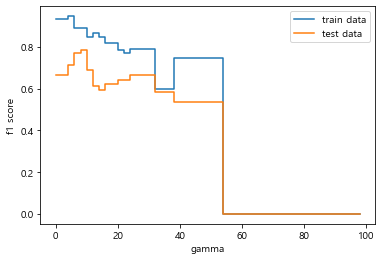

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel("gamma")
ax.set_ylabel("f1 score")
#ax.set_title("나무 복잡도 증가에 따른 오분류율 그래프")
ax.plot(ccp_alpha_list, train_scores,  label="train data", drawstyle="steps-post")
ax.plot(ccp_alpha_list, test_scores,  label="test data", drawstyle="steps-post")

#ax.plot(ccp_alpha_list, pd.Series(train_scores).rolling(10,center =True).mean(),  label="train data", drawstyle="steps-post")
#ax.plot(ccp_alpha_list, pd.Series(test_scores).rolling(10,center=True).mean(),  label="test data", drawstyle="steps-post")

#ax.plot(ccp_alpha_list, train_scores, drawstyle="steps-post")
#ax.plot(ccp_alpha_list, test_scores, drawstyle="steps-post")

ax.legend()
#plt.xlim(0.7)
plt.show()
plt.close('all')

- 감마값의 증가에 따라, 더 많은 가지치기가 수행되어 모델 성능이 낮아짐

### 5. LAMBDA에 따른 변화


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20,shuffle =True)

# 0.4 0.7, 0.8

In [15]:

from xgboost import XGBClassifier
eval_set = [(X_test, Y_test)]

ccp_alpha_list = list(np.arange(0,10,0.5)) # 0부터 9.5까지 0.5간격으로 출력하여 리스트 형태로 반환
#ccp_alpha_list = [0.1,0.5,0.9]

train_scores =[]
test_scores =[]

for alpha in ccp_alpha_list: # 모든 alpha값에 대하여 모델 적합, 최적의 람다값 도출

    clf = XGBClassifier(use_label_encoder = False,
                        n_estimators = 200,
                        learning_rate = 0.6,
                        min_child_weight = 10,
                        colsample_bytree = 0.5,
                        max_depth = 8 , gamma = 6, reg_lambda = alpha, eval_metric='logloss')

    clf.fit(X_train,Y_train,eval_set = eval_set,early_stopping_rounds = 20) # 검증용 데이터셋에서 eval_metric(=logloss) 결과가 20회동안 개선되지 않으면 조기종료

    preds_train = clf.predict(X_train) # 훈련데이터로 y값 예측
    preds = clf.predict(X_test) # 테스트데이터로 y값 예측

    train_scores.append(f1_score(Y_train,preds_train)) # 훈련성능 평가
    test_scores.append(f1_score(Y_test,preds)) # 테스트성능 평가



[0]	validation_0-logloss:0.53226
[1]	validation_0-logloss:0.47765
[2]	validation_0-logloss:0.41612
[3]	validation_0-logloss:0.37930
[4]	validation_0-logloss:0.36353
[5]	validation_0-logloss:0.37633
[6]	validation_0-logloss:0.36331
[7]	validation_0-logloss:0.34635
[8]	validation_0-logloss:0.34629
[9]	validation_0-logloss:0.34027
[10]	validation_0-logloss:0.34019
[11]	validation_0-logloss:0.34015
[12]	validation_0-logloss:0.34014
[13]	validation_0-logloss:0.34014
[14]	validation_0-logloss:0.34013
[15]	validation_0-logloss:0.34013
[16]	validation_0-logloss:0.34013
[17]	validation_0-logloss:0.34013
[18]	validation_0-logloss:0.34013
[19]	validation_0-logloss:0.34013
[20]	validation_0-logloss:0.34013
[21]	validation_0-logloss:0.34013
[22]	validation_0-logloss:0.34013
[23]	validation_0-logloss:0.34013
[24]	validation_0-logloss:0.34013
[25]	validation_0-logloss:0.34013
[26]	validation_0-logloss:0.34013
[27]	validation_0-logloss:0.34013
[28]	validation_0-logloss:0.34013
[29]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.34013
[0]	validation_0-logloss:0.53534
[1]	validation_0-logloss:0.47877
[2]	validation_0-logloss:0.41798
[3]	validation_0-logloss:0.38119
[4]	validation_0-logloss:0.36539
[5]	validation_0-logloss:0.37774
[6]	validation_0-logloss:0.36449
[7]	validation_0-logloss:0.34696
[8]	validation_0-logloss:0.34697
[9]	validation_0-logloss:0.34049
[10]	validation_0-logloss:0.34046
[11]	validation_0-logloss:0.34044
[12]	validation_0-logloss:0.34044
[13]	validation_0-logloss:0.34044
[14]	validation_0-logloss:0.34044
[15]	validation_0-logloss:0.34043
[16]	validation_0-logloss:0.34043
[17]	validation_0-logloss:0.34043
[18]	validation_0-logloss:0.34043
[19]	validation_0-logloss:0.34043
[20]	validation_0-logloss:0.34043
[21]	validation_0-logloss:0.34043
[22]	validation_0-logloss:0.34043
[23]	validation_0-logloss:0.34043
[24]	validation_0-logloss:0.34043
[25]	validation_0-logloss:0.34043
[26]	validation_0-logloss:0.34043
[27]	validation_0-logloss:0.34043
[28]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.53833
[1]	validation_0-logloss:0.47093
[2]	validation_0-logloss:0.41783
[3]	validation_0-logloss:0.37678
[4]	validation_0-logloss:0.36222
[5]	validation_0-logloss:0.35210
[6]	validation_0-logloss:0.35193
[7]	validation_0-logloss:0.33431
[8]	validation_0-logloss:0.33434
[9]	validation_0-logloss:0.33435
[10]	validation_0-logloss:0.33436
[11]	validation_0-logloss:0.33436
[12]	validation_0-logloss:0.33436
[13]	validation_0-logloss:0.33436
[14]	validation_0-logloss:0.33436
[15]	validation_0-logloss:0.33436
[16]	validation_0-logloss:0.33436
[17]	validation_0-logloss:0.33436
[18]	validation_0-logloss:0.33436
[19]	validation_0-logloss:0.33436
[20]	validation_0-logloss:0.33436
[21]	validation_0-logloss:0.33436
[22]	validation_0-logloss:0.33436
[23]	validation_0-logloss:0.33436
[24]	validation_0-logloss:0.33436
[25]	validation_0-logloss:0.33436
[26]	validation_0-logloss:0.33436
[0]	validation_0-logloss:0.54125
[1]	validation_0-logloss:0.47506
[2]	validation_0-logloss:0

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.50762
[2]	validation_0-logloss:0.43500
[3]	validation_0-logloss:0.42959
[4]	validation_0-logloss:0.41185
[5]	validation_0-logloss:0.36858
[6]	validation_0-logloss:0.35414
[7]	validation_0-logloss:0.33665
[8]	validation_0-logloss:0.33685
[9]	validation_0-logloss:0.33693
[10]	validation_0-logloss:0.33697
[11]	validation_0-logloss:0.33699
[12]	validation_0-logloss:0.33700
[13]	validation_0-logloss:0.33700
[14]	validation_0-logloss:0.33700
[15]	validation_0-logloss:0.33700
[16]	validation_0-logloss:0.33700
[17]	validation_0-logloss:0.33700
[18]	validation_0-logloss:0.33700
[19]	validation_0-logloss:0.33700
[20]	validation_0-logloss:0.33700
[21]	validation_0-logloss:0.33700
[22]	validation_0-logloss:0.33700
[23]	validation_0-logloss:0.33700
[24]	validation_0-logloss:0.33700
[25]	validation_0-logloss:0.33700
[26]	validation_0-logloss:0.33700
[0]	validation_0-logloss:0.57303
[1]	validation_0-logloss:0.50963
[2]	validation_0-logloss:0.46017
[3]	validation_0-logloss:0

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.43874
[5]	validation_0-logloss:0.39032
[6]	validation_0-logloss:0.37087
[7]	validation_0-logloss:0.35173
[8]	validation_0-logloss:0.35145
[9]	validation_0-logloss:0.35133
[10]	validation_0-logloss:0.35127
[11]	validation_0-logloss:0.35125
[12]	validation_0-logloss:0.35124
[13]	validation_0-logloss:0.35123
[14]	validation_0-logloss:0.35123
[15]	validation_0-logloss:0.35123
[16]	validation_0-logloss:0.35123
[17]	validation_0-logloss:0.35123
[18]	validation_0-logloss:0.35123
[19]	validation_0-logloss:0.35123
[20]	validation_0-logloss:0.35123
[21]	validation_0-logloss:0.35123
[22]	validation_0-logloss:0.35123
[23]	validation_0-logloss:0.35123
[24]	validation_0-logloss:0.35123
[25]	validation_0-logloss:0.35123
[26]	validation_0-logloss:0.35123
[27]	validation_0-logloss:0.35123
[28]	validation_0-logloss:0.35123
[29]	validation_0-logloss:0.35123
[30]	validation_0-logloss:0.35123
[31]	validation_0-logloss:0.35123
[32]	validation_0-logloss:0.35123
[33]	validation_0-lo

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.41138
[5]	validation_0-logloss:0.37834
[6]	validation_0-logloss:0.36849
[7]	validation_0-logloss:0.35844
[8]	validation_0-logloss:0.35860
[9]	validation_0-logloss:0.35869
[10]	validation_0-logloss:0.35872
[11]	validation_0-logloss:0.35874
[12]	validation_0-logloss:0.35875
[13]	validation_0-logloss:0.35875
[14]	validation_0-logloss:0.35876
[15]	validation_0-logloss:0.35876
[16]	validation_0-logloss:0.35876
[17]	validation_0-logloss:0.35876
[18]	validation_0-logloss:0.35876
[19]	validation_0-logloss:0.35876
[20]	validation_0-logloss:0.35876
[21]	validation_0-logloss:0.35876
[22]	validation_0-logloss:0.35876
[23]	validation_0-logloss:0.35876
[24]	validation_0-logloss:0.35876
[25]	validation_0-logloss:0.35876
[26]	validation_0-logloss:0.35876
[27]	validation_0-logloss:0.35876
[0]	validation_0-logloss:0.57553
[1]	validation_0-logloss:0.51028
[2]	validation_0-logloss:0.45253
[3]	validation_0-logloss:0.42349
[4]	validation_0-logloss:0.40795
[5]	validation_0-logloss:

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.41056
[7]	validation_0-logloss:0.38826
[8]	validation_0-logloss:0.38854
[9]	validation_0-logloss:0.38868
[10]	validation_0-logloss:0.38875
[11]	validation_0-logloss:0.38879
[12]	validation_0-logloss:0.38880
[13]	validation_0-logloss:0.38881
[14]	validation_0-logloss:0.38882
[15]	validation_0-logloss:0.38882
[16]	validation_0-logloss:0.38882
[17]	validation_0-logloss:0.38882
[18]	validation_0-logloss:0.38882
[19]	validation_0-logloss:0.38882
[20]	validation_0-logloss:0.38882
[21]	validation_0-logloss:0.38882
[22]	validation_0-logloss:0.38882
[23]	validation_0-logloss:0.38882
[24]	validation_0-logloss:0.38882
[25]	validation_0-logloss:0.38882
[26]	validation_0-logloss:0.38882
[0]	validation_0-logloss:0.57805
[1]	validation_0-logloss:0.51352
[2]	validation_0-logloss:0.45667
[3]	validation_0-logloss:0.42745
[4]	validation_0-logloss:0.41152
[5]	validation_0-logloss:0.42585
[6]	validation_0-logloss:0.41202
[7]	validation_0-logloss:0.38955
[8]	validation_0-logloss:0

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-logloss:0.42942
[4]	validation_0-logloss:0.41332
[5]	validation_0-logloss:0.42723
[6]	validation_0-logloss:0.41352
[7]	validation_0-logloss:0.39088
[8]	validation_0-logloss:0.39119
[9]	validation_0-logloss:0.39135
[10]	validation_0-logloss:0.39144
[11]	validation_0-logloss:0.39148
[12]	validation_0-logloss:0.39150
[13]	validation_0-logloss:0.39151
[14]	validation_0-logloss:0.39151
[15]	validation_0-logloss:0.39151
[16]	validation_0-logloss:0.39152
[17]	validation_0-logloss:0.39152
[18]	validation_0-logloss:0.39152
[19]	validation_0-logloss:0.39152
[20]	validation_0-logloss:0.39152
[21]	validation_0-logloss:0.39152
[22]	validation_0-logloss:0.39152
[23]	validation_0-logloss:0.39152
[24]	validation_0-logloss:0.39152
[25]	validation_0-logloss:0.39152
[26]	validation_0-logloss:0.39152
[27]	validation_0-logloss:0.39152
[0]	validation_0-logloss:0.58050
[1]	validation_0-logloss:0.51673
[2]	validation_0-logloss:0.46074
[3]	validation_0-logloss:0.43137
[4]	validation_0-logloss:

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-logloss:0.41030
[9]	validation_0-logloss:0.41039
[10]	validation_0-logloss:0.39767
[11]	validation_0-logloss:0.39767
[12]	validation_0-logloss:0.39766
[13]	validation_0-logloss:0.39766
[14]	validation_0-logloss:0.39766
[15]	validation_0-logloss:0.39766
[16]	validation_0-logloss:0.39766
[17]	validation_0-logloss:0.39766
[18]	validation_0-logloss:0.39766
[19]	validation_0-logloss:0.39766
[20]	validation_0-logloss:0.39766
[21]	validation_0-logloss:0.39766
[22]	validation_0-logloss:0.39766
[23]	validation_0-logloss:0.39766
[24]	validation_0-logloss:0.39766
[0]	validation_0-logloss:0.58288
[1]	validation_0-logloss:0.51989
[2]	validation_0-logloss:0.47689
[3]	validation_0-logloss:0.45421
[4]	validation_0-logloss:0.42868
[5]	validation_0-logloss:0.39527
[6]	validation_0-logloss:0.40696
[7]	validation_0-logloss:0.40729
[8]	validation_0-logloss:0.40745
[9]	validation_0-logloss:0.40754
[10]	validation_0-logloss:0.39249
[11]	validation_0-logloss:0.39246
[12]	validation_0-logloss:

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.39243
[46]	validation_0-logloss:0.39243
[47]	validation_0-logloss:0.39243
[48]	validation_0-logloss:0.39243
[49]	validation_0-logloss:0.39243
[50]	validation_0-logloss:0.39243
[51]	validation_0-logloss:0.39243
[52]	validation_0-logloss:0.39243
[53]	validation_0-logloss:0.39243
[54]	validation_0-logloss:0.39243
[0]	validation_0-logloss:0.58405
[1]	validation_0-logloss:0.52144
[2]	validation_0-logloss:0.47864
[3]	validation_0-logloss:0.45582
[4]	validation_0-logloss:0.43027
[5]	validation_0-logloss:0.39687
[6]	validation_0-logloss:0.40825
[7]	validation_0-logloss:0.40857
[8]	validation_0-logloss:0.40874
[9]	validation_0-logloss:0.40883
[10]	validation_0-logloss:0.39394
[11]	validation_0-logloss:0.39391
[12]	validation_0-logloss:0.39390
[13]	validation_0-logloss:0.39389
[14]	validation_0-logloss:0.39389
[15]	validation_0-logloss:0.39389
[16]	validation_0-logloss:0.39389
[17]	validation_0-logloss:0.39389
[18]	validation_0-logloss:0.39389
[19]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.39389
[0]	validation_0-logloss:0.58520
[1]	validation_0-logloss:0.52298
[2]	validation_0-logloss:0.48037
[3]	validation_0-logloss:0.45743
[4]	validation_0-logloss:0.43186
[5]	validation_0-logloss:0.39848
[6]	validation_0-logloss:0.40956
[7]	validation_0-logloss:0.40988
[8]	validation_0-logloss:0.41005
[9]	validation_0-logloss:0.41014
[10]	validation_0-logloss:0.39540
[11]	validation_0-logloss:0.39538
[12]	validation_0-logloss:0.39537
[13]	validation_0-logloss:0.39537
[14]	validation_0-logloss:0.39537
[15]	validation_0-logloss:0.39537
[16]	validation_0-logloss:0.39537
[17]	validation_0-logloss:0.39536
[18]	validation_0-logloss:0.39536
[19]	validation_0-logloss:0.39536
[20]	validation_0-logloss:0.39536
[21]	validation_0-logloss:0.39536
[22]	validation_0-logloss:0.39536
[23]	validation_0-logloss:0.39536
[24]	validation_0-logloss:0.39536
[25]	validation_0-logloss:0.39536
[26]	validation_0-logloss:0.39536
[27]	validation_0-logloss:0.39536
[28]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.58633
[1]	validation_0-logloss:0.52450
[2]	validation_0-logloss:0.48208
[3]	validation_0-logloss:0.45903
[4]	validation_0-logloss:0.43344
[5]	validation_0-logloss:0.40008
[6]	validation_0-logloss:0.41089
[7]	validation_0-logloss:0.41121
[8]	validation_0-logloss:0.41138
[9]	validation_0-logloss:0.41147
[10]	validation_0-logloss:0.39688
[11]	validation_0-logloss:0.39687
[12]	validation_0-logloss:0.39686
[13]	validation_0-logloss:0.39686
[14]	validation_0-logloss:0.39686
[15]	validation_0-logloss:0.39685
[16]	validation_0-logloss:0.39685
[17]	validation_0-logloss:0.39685
[18]	validation_0-logloss:0.39685
[19]	validation_0-logloss:0.39685
[20]	validation_0-logloss:0.39685
[21]	validation_0-logloss:0.39685
[22]	validation_0-logloss:0.39685
[23]	validation_0-logloss:0.39685
[24]	validation_0-logloss:0.39685
[25]	validation_0-logloss:0.39685
[26]	validation_0-logloss:0.39685
[27]	validation_0-logloss:0.39685
[28]	validation_0-logloss:0.39685
[29]	validation_0-loglos

c:\Users\SIL\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.39835


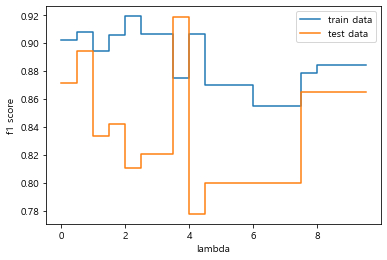

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel("lambda")
ax.set_ylabel("f1 score")
#ax.set_title("나무 복잡도 증가에 따른 오분류율 그래프")
# ax.plot(ccp_alpha_list, pd.Series(train_scores).rolling(10,center =True).mean(),  label="train data", drawstyle="steps-post")
# ax.plot(ccp_alpha_list, pd.Series(test_scores).rolling(10,center=True).mean(),  label="test data", drawstyle="steps-post")

ax.plot(ccp_alpha_list, train_scores,  label="train data", drawstyle="steps-post")
ax.plot(ccp_alpha_list, test_scores,  label="test data", drawstyle="steps-post")

#ax.plot(ccp_alpha_list, train_scores, drawstyle="steps-post")
#ax.plot(ccp_alpha_list, test_scores, drawstyle="steps-post")

ax.legend()
#plt.xlim(0.7)
plt.show()
plt.close('all')

- 람다값이 증가함에 따라, 출력값을 작게 만들어 특정 구간에서 과적합이 개선되는 것을 볼 수 있다.

In [20]:
test_scores

[0.8717948717948718,
 0.8947368421052632,
 0.8333333333333333,
 0.8421052631578947,
 0.8108108108108109,
 0.8205128205128205,
 0.8205128205128205,
 0.918918918918919,
 0.7777777777777778,
 0.7999999999999999,
 0.7999999999999999,
 0.7999999999999999,
 0.7999999999999999,
 0.7999999999999999,
 0.7999999999999999,
 0.8648648648648649,
 0.8648648648648649,
 0.8648648648648649,
 0.8648648648648649,
 0.8648648648648649]

In [22]:
test_scores[19]

0.8648648648648649